# 📊 EDA Completo - Ventas Globales de Notebooks (2020-2024)

Este notebook amplía el análisis exploratorio de datos del proyecto **Ventas Globales de Notebooks**, abarcando:
- Calidad de datos: nulos, duplicados y outliers
- KPIs clave: market share, tendencias anuales, unidades por continente y análisis de ingresos
- Visualizaciones avanzadas listas para replicar en Tableau y AWS Athena

**Pipeline completo:**
```
AWS S3 (Bronze → Silver) → Athena (Gold) → Tableau Public
```

In [1]:
# ============================================================
# ⚙️ 1. Importación de librerías
# ============================================================
import pandas as pd
import boto3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style='whitegrid', palette='muted')
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
# ============================================================
# 📥 2. Lectura de datos desde capa Silver (S3)
# ============================================================
bucket_name = 'notebooks-datalake-oalvarez'
silver_key = 'silver/notebooks_ventas_clean.csv'

s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket_name, Key=silver_key)
df = pd.read_csv(obj['Body'])

print('✅ Dataset cargado correctamente desde S3 (Silver)')
print(df.head())

✅ Dataset cargado correctamente desde S3 (Silver)
    año trimestre    marca  unidades_vendidas  ingreso_total continente
0  2022        Q3       Hp            2838341   2.318925e+09       Asia
1  2023        Q3  Samsung            5201221   5.388465e+09     África
2  2023        Q3   Lenovo            2771890   2.123268e+09    Oceanía
3  2023        Q2   Lenovo            2585840   3.550358e+09     Europa
4  2022        Q1       Hp            4377789   6.028215e+09     Europa


## 🔍 3. Análisis de calidad de datos

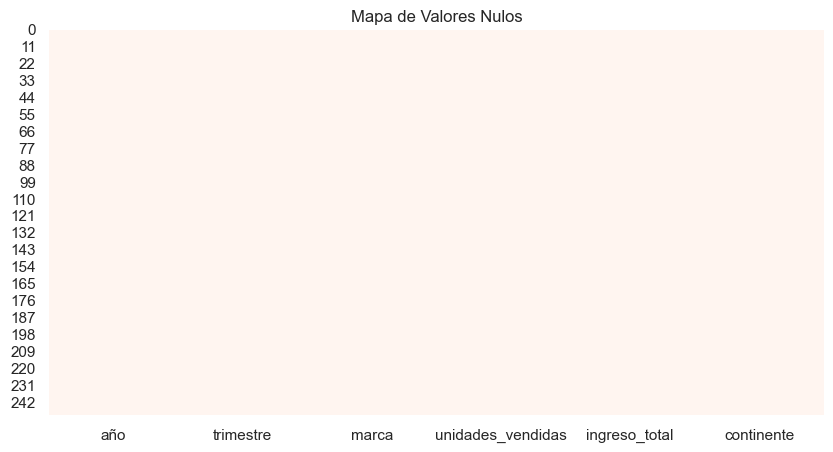

Valores nulos por columna:
año                  0
trimestre            0
marca                0
unidades_vendidas    0
ingreso_total        0
continente           0
dtype: int64


In [6]:
# --- Valores nulos ---
plt.figure(figsize=(10,5))
sns.heatmap(df.isnull(), cbar=False, cmap='Reds')
plt.title('Mapa de Valores Nulos')
plt.show()

print('Valores nulos por columna:')
print(df.isnull().sum())

No se observan valores nulos por columna

**Registro de duplicados**

In [7]:
# --- Duplicados ---
duplicados = df.duplicated().sum()
print(f'🔁 Registros duplicados: {duplicados}')
if duplicados > 0:
    df = df.drop_duplicates()
    print('✅ Duplicados eliminados')

🔁 Registros duplicados: 0


**Registro de outliers**

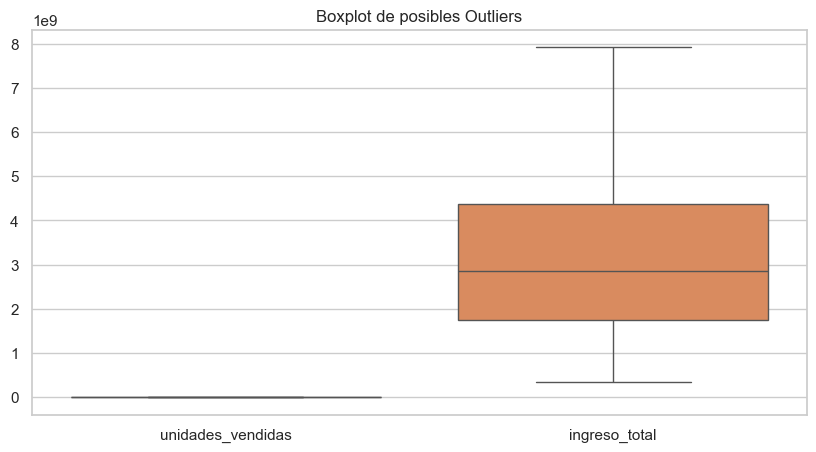

🚨 Outliers detectados por variable:
unidades_vendidas    0
ingreso_total        0
dtype: int64


In [8]:
# --- Outliers ---
plt.figure(figsize=(10,5))
sns.boxplot(data=df[['unidades_vendidas','ingreso_total']])
plt.title('Boxplot de posibles Outliers')
plt.show()

Q1 = df[['unidades_vendidas','ingreso_total']].quantile(0.25)
Q3 = df[['unidades_vendidas','ingreso_total']].quantile(0.75)
IQR = Q3 - Q1
outliers = ((df[['unidades_vendidas','ingreso_total']] < (Q1 - 1.5 * IQR)) | (df[['unidades_vendidas','ingreso_total']] > (Q3 + 1.5 * IQR))).sum()
print('🚨 Outliers detectados por variable:')
print(outliers)



El gráfico de **boxplot** permite visualizar la distribución de las variables **`unidades_vendidas`** e **`ingreso_total`**, y detectar posibles valores atípicos.

En este caso, el cálculo estadístico mediante el **rango intercuartílico (IQR)** no detectó outliers formales (`0` en ambas variables). Esto se debe a que los valores se encuentran dentro del rango esperado:

- **`unidades_vendidas`** presenta **baja dispersión**, lo que indica una distribución bastante homogénea entre las marcas.  
- **`ingreso_total`**, en cambio, muestra una **gran amplitud** en el boxplot, reflejando diferencias reales en la generación de ingresos entre marcas o regiones.  

A pesar de no existir outliers estadísticos, la dispersión visual sigue siendo importante: algunas marcas generan **ingresos muy superiores al promedio** debido a estrategias de precios más altas o posicionamiento premium.

Por lo tanto, estos valores deben **mantenerse en el análisis**, ya que representan **comportamientos reales del mercado** y no errores en los datos.


## 📊 4. Market Share por marca

C:\Users\octav\AppData\Local\Temp\ipykernel_10840\209673844.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=market_share, x='market_share_%', y='marca', palette='Blues_r')


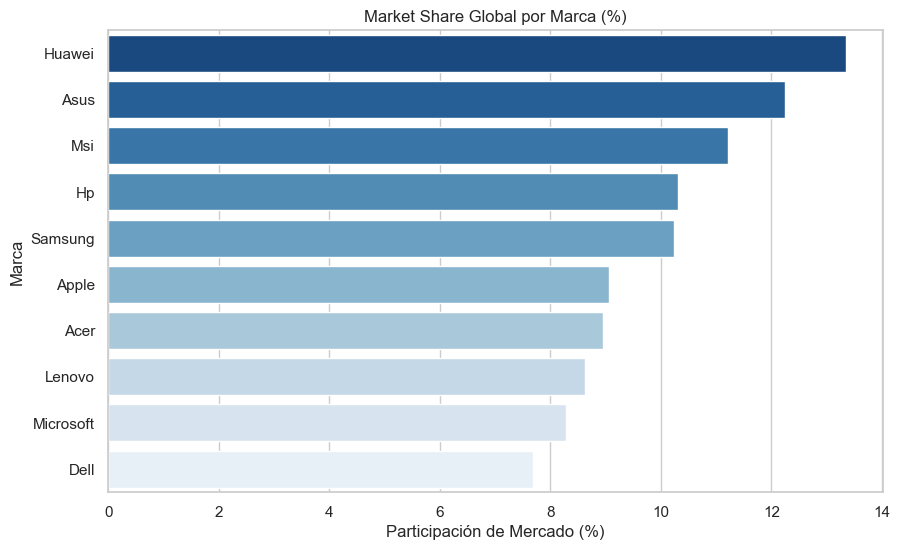

In [9]:
market_share = df.groupby('marca')['unidades_vendidas'].sum().reset_index().sort_values(by='unidades_vendidas', ascending=False)
market_share['market_share_%'] = 100 * market_share['unidades_vendidas'] / market_share['unidades_vendidas'].sum()

sns.barplot(data=market_share, x='market_share_%', y='marca', palette='Blues_r')
plt.title('Market Share Global por Marca (%)')
plt.xlabel('Participación de Mercado (%)')
plt.ylabel('Marca')
plt.show()


El gráfico muestra la **participación de mercado** de cada marca en el total de unidades vendidas entre **2020 y 2024**.

Se observa que:

- **Huawei** lidera el mercado con la mayor participación global, superando el **13 %** del total de unidades vendidas.  
- **Asus**, **MSI**, **HP** y **Samsung** completan el grupo de las principales competidoras, manteniendo cuotas de mercado superiores al **10 %**.  
- Las marcas tradicionales como **Apple**, **Acer** y **Lenovo** presentan participaciones intermedias, lo que podría deberse a estrategias más focalizadas o a menor presencia en determinadas regiones.  
- **Dell** y **Microsoft** se ubican en el segmento inferior, posiblemente con estrategias orientadas a nichos específicos o ventas corporativas.  

En conjunto, el mercado presenta un comportamiento **oligopólico**, donde unas pocas marcas concentran gran parte de las ventas globales, lo cual puede influir en las **estrategias de precios, distribución y marketing** a nivel internacional.


## 📈 5. Tendencia anual - Top 5 marcas

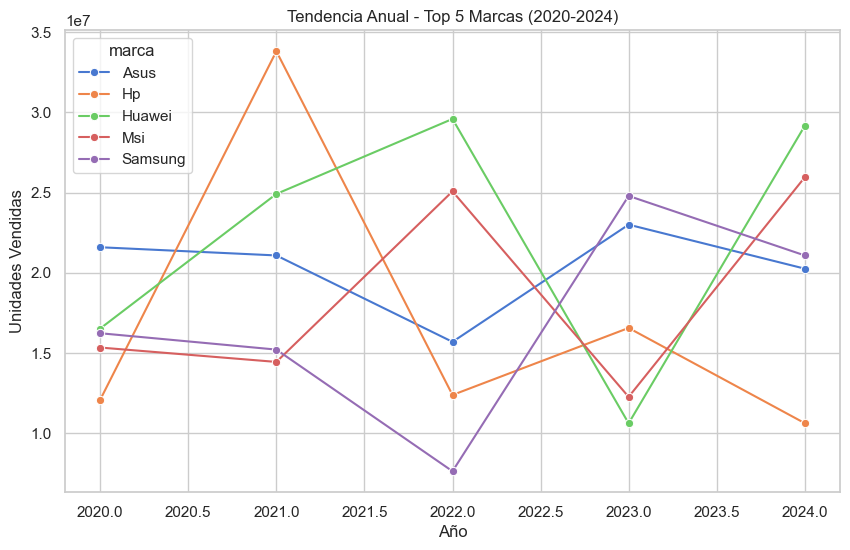

In [12]:
top5 = df.groupby('marca')['unidades_vendidas'].sum().nlargest(5).index
trend_top5 = df[df['marca'].isin(top5)].groupby(['año','marca'])['unidades_vendidas'].sum().reset_index()

sns.lineplot(data=trend_top5, x='año', y='unidades_vendidas', hue='marca', marker='o')
plt.title('Tendencia Anual - Top 5 Marcas (2020-2024)')
plt.xlabel('Año')
plt.ylabel('Unidades Vendidas')
plt.show()



El gráfico de líneas muestra la **evolución anual de unidades vendidas** para las cinco marcas con mayor participación de mercado en el período **2020–2024**.

Se observa que:

- **Huawei** y **MSI** presentan un crecimiento sostenido en la mayoría de los años, destacándose como las marcas más dinámicas del mercado.  
- **HP** tiene un comportamiento más volátil, con picos pronunciados en 2021 y descensos posteriores, lo que sugiere fluctuaciones en su estrategia comercial o disponibilidad de productos.  
- **Asus** mantiene una tendencia relativamente estable, con leves variaciones a lo largo del tiempo, indicando consistencia en sus ventas.  
- **Samsung** muestra una recuperación hacia los años finales del período, posiblemente impulsada por nuevos lanzamientos o mayor penetración regional.  

En conjunto, el gráfico refleja un mercado competitivo con **marcas que alternan el liderazgo según el año**, destacando la importancia de la innovación, la estacionalidad y la adaptación a las condiciones económicas globales.


## 🌍 6. Unidades por continente y marca

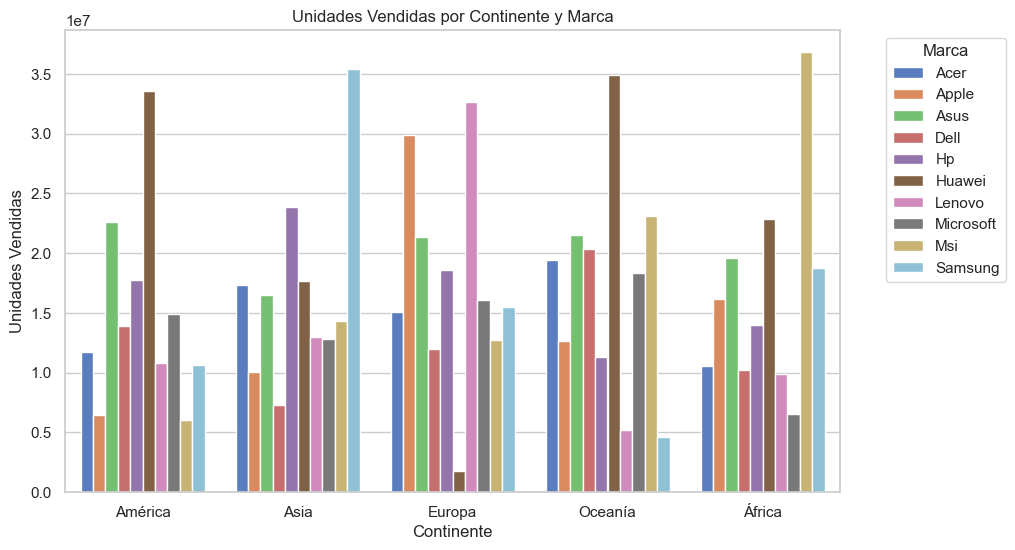

In [13]:
continent_brand = df.groupby(['continente','marca'])['unidades_vendidas'].sum().reset_index()
sns.barplot(data=continent_brand, x='continente', y='unidades_vendidas', hue='marca')
plt.title('Unidades Vendidas por Continente y Marca')
plt.xlabel('Continente')
plt.ylabel('Unidades Vendidas')
plt.legend(title='Marca', bbox_to_anchor=(1.05,1))
plt.show()



El gráfico presenta la **distribución de unidades vendidas** por continente, diferenciadas por marca, lo que permite analizar el **desempeño geográfico** de cada fabricante.

Se observa que:

- **Huawei** se destaca con fuertes ventas en **América** y **Oceanía**, lo que refleja su consolidación en mercados emergentes y una expansión fuera de Asia.  
- **Lenovo** y **Apple** muestran una **alta concentración en Europa**, posiblemente por su posicionamiento en segmentos premium y corporativos.  
- **MSI** mantiene un **rendimiento equilibrado**, con buenas cifras en África y Oceanía, lo que indica una estrategia diversificada a nivel global.  
- **Samsung** y **HP** presentan una distribución estable en casi todos los continentes, mostrando una presencia global sólida y consistente.  

En general, los datos evidencian una **competencia global con diferencias regionales marcadas**: algunas marcas priorizan regiones tecnológicamente maduras (como Europa), mientras que otras apuestan por mercados en expansión (como América o África).


## 💰 7. Ingreso vs Unidades con Precio Promedio

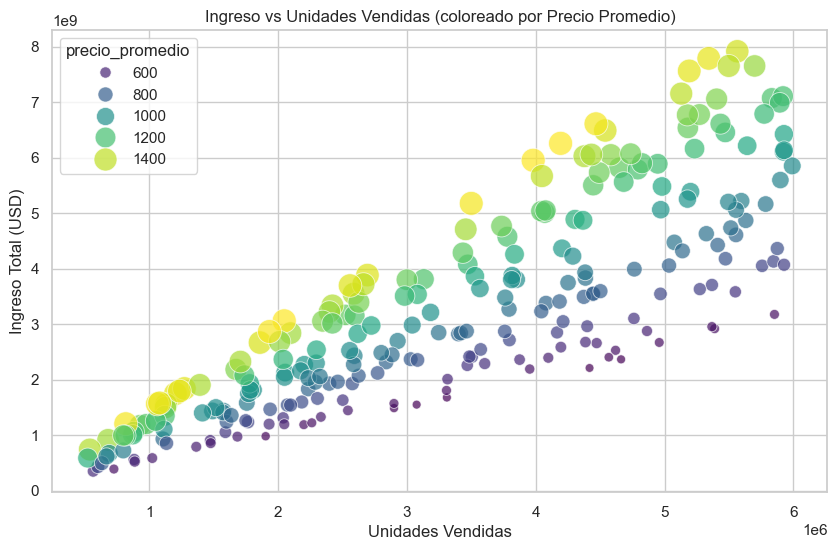

In [14]:
df['precio_promedio'] = df['ingreso_total'] / df['unidades_vendidas']
sns.scatterplot(data=df, x='unidades_vendidas', y='ingreso_total', hue='precio_promedio', size='precio_promedio', sizes=(40,300), palette='viridis', alpha=0.7)
plt.title('Ingreso vs Unidades Vendidas (coloreado por Precio Promedio)')
plt.xlabel('Unidades Vendidas')
plt.ylabel('Ingreso Total (USD)')
plt.show()


El gráfico de dispersión muestra la relación entre las variables **unidades vendidas** (eje X) y **ingreso total** (eje Y), utilizando el **precio promedio** como variable de color y tamaño de los puntos.

Se observa que:

- Existe una **correlación positiva clara**: a mayor número de unidades vendidas, mayor ingreso total, lo cual valida la consistencia de los datos.  
- Los puntos con colores más claros (amarillos y verdes) representan productos con **precios promedio más altos**, lo que indica una estrategia de posicionamiento **premium**.  
- Los puntos en tonos más oscuros (azules y violetas) corresponden a productos de **menor precio**, típicos de estrategias de **volumen o gama media-baja**.  
- Se identifican distintos “bloques” de precios, lo que sugiere la existencia de **segmentos de mercado diferenciados** dentro del sector de notebooks.  

En síntesis, este gráfico permite identificar cómo las marcas con **productos de mayor valor unitario** pueden generar ingresos comparables o superiores con menor volumen de ventas, mientras que las marcas más económicas dependen de un **mayor volumen de unidades** para alcanzar cifras similares.


## 🏆 8. Top 5 marcas por ingreso total

C:\Users\octav\AppData\Local\Temp\ipykernel_10840\3128838819.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top5_ingresos, x='ingreso_total', y='marca', palette='coolwarm')


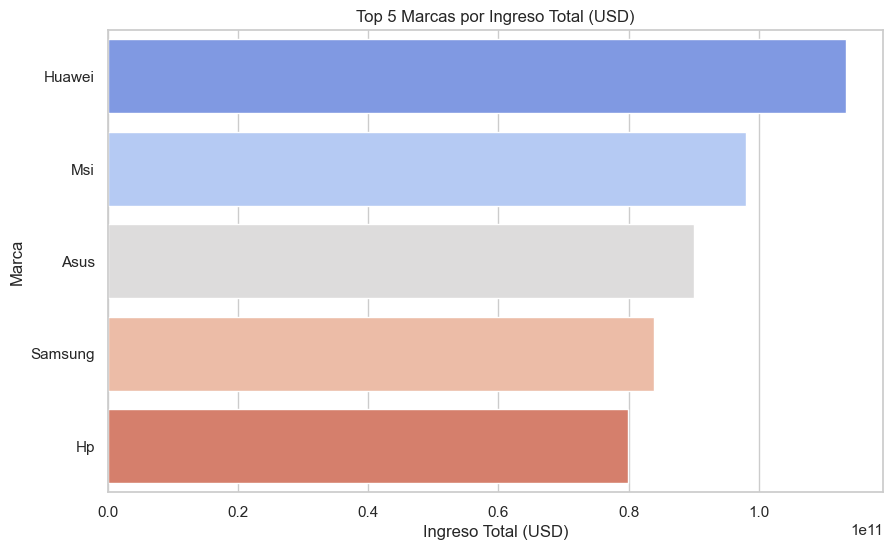

In [15]:
top5_ingresos = df.groupby('marca')['ingreso_total'].sum().reset_index().sort_values(by='ingreso_total', ascending=False).head(5)
sns.barplot(data=top5_ingresos, x='ingreso_total', y='marca', palette='coolwarm')
plt.title('Top 5 Marcas por Ingreso Total (USD)')
plt.xlabel('Ingreso Total (USD)')
plt.ylabel('Marca')
plt.show()



El gráfico muestra el **ranking de las cinco marcas con mayor ingreso total** acumulado en el período **2020–2024**, permitiendo identificar a los principales líderes del mercado.

Se observa que:

- **Huawei** ocupa el primer lugar con el **mayor volumen de ingresos**, consolidándose como la marca más rentable del sector.  
- **MSI** y **Asus** se posicionan en segundo y tercer lugar respectivamente, con niveles de facturación muy competitivos, impulsados por una combinación de precios medios-altos y fuerte volumen de ventas.  
- **Samsung** y **HP** completan el top 5, demostrando una presencia sólida y sostenida en el mercado global.  

En general, los resultados reflejan un mercado **altamente concentrado**, donde unas pocas marcas generan la mayor parte de los ingresos totales. Este patrón indica **ventajas competitivas claras** en términos de innovación, posicionamiento y alcance internacional.


## 🔥 9. Heatmap Unidades Vendidas por Marca y Año

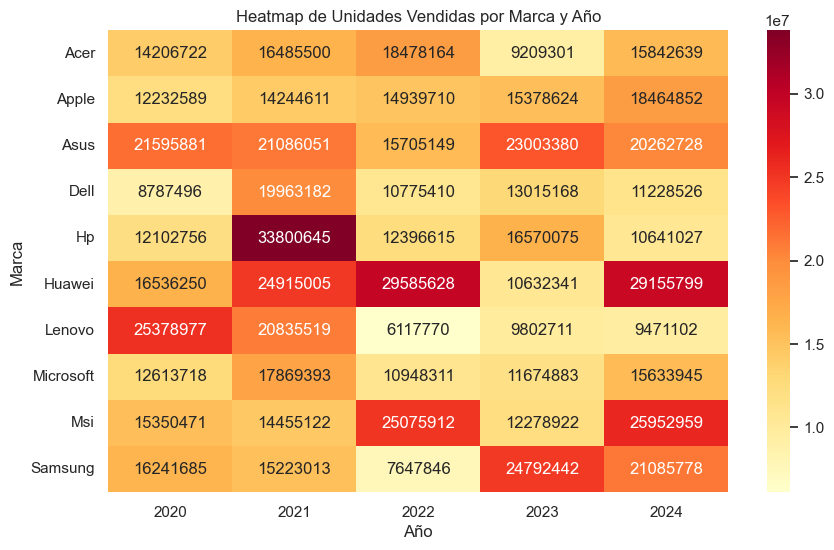

In [17]:
heatmap_data = df.pivot_table(values='unidades_vendidas', index='marca', columns='año', aggfunc='sum')
sns.heatmap(heatmap_data, cmap='YlOrRd', annot=True, fmt='.0f')
plt.title('Heatmap de Unidades Vendidas por Marca y Año')
plt.xlabel('Año')
plt.ylabel('Marca')
plt.show()



El heatmap muestra la **evolución anual de las unidades vendidas** por cada marca entre **2020 y 2024**, permitiendo identificar patrones de crecimiento, estabilidad o descenso a lo largo del tiempo.

Se observa que:

- **Huawei**, **MSI** y **HP** presentan los valores más altos en varios años, destacándose por su **consistencia y fuerte presencia global**.  
- Algunas marcas, como **Lenovo** y **Asus**, muestran **picos específicos** en determinados años (2020 y 2023), lo que puede estar relacionado con lanzamientos exitosos o campañas regionales.  
- **Dell** y **Microsoft** mantienen volúmenes más moderados, sin grandes fluctuaciones, indicando un enfoque más estable o corporativo.  
- En general, la intensidad de los colores evidencia que **2021 y 2022 fueron años de fuerte rendimiento** para la mayoría de las marcas, seguidos de cierta desaceleración en 2023.

Este tipo de visualización permite **detectar rápidamente cambios de tendencia** y analizar el impacto temporal de las estrategias comerciales, lanzamientos o variaciones en la demanda global de notebooks.


## 🧭 Conclusiones Finales del Análisis Exploratorio (EDA)

El análisis exploratorio permitió comprender en profundidad el comportamiento del mercado global de notebooks entre **2020 y 2024**, identificando patrones de venta, desempeño por marca y diferencias regionales relevantes.

### 🔍 Hallazgos Principales

- **Huawei** lidera tanto en **ingresos totales** como en **participación de mercado**, consolidándose como la marca más rentable del período analizado.  
- **MSI**, **Asus**, **Samsung** y **HP** conforman el grupo de marcas más competitivas, con una combinación efectiva entre volumen de ventas y posicionamiento de precios.  
- Los **años 2021 y 2022** marcaron el punto más alto en ventas para la mayoría de las marcas, posiblemente impulsados por el aumento de la demanda tecnológica post-pandemia.  
- A nivel geográfico, **Europa y América** concentran los mayores volúmenes de venta, mientras que **África y Oceanía** muestran oportunidades de expansión.  
- El análisis de **ingreso vs unidades vendidas** revela la existencia de **estrategias diferenciadas**: algunas marcas priorizan volumen, mientras que otras apuestan por precios más altos y márgenes superiores.  
- No se detectaron **outliers estadísticos significativos**, pero sí se observó una **alta dispersión visual** en los ingresos, reflejando diferencias reales en el posicionamiento de mercado.

### 📊 Conclusión General

El mercado global de notebooks presenta una estructura **oligopólica**, dominada por pocas marcas con fuerte poder competitivo.  
Las tendencias indican que la **innovación, el pricing estratégico y la diversificación regional** serán factores clave para sostener el crecimiento futuro.  

Este análisis sienta las bases para la siguiente etapa del proyecto: la **construcción de dashboards interactivos en Tableau**, donde se podrán explorar en detalle los KPIs y tendencias identificadas en este EDA.
